In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mino
import sklearn
import pickle

In [2]:
%load_ext watermark

In [3]:
%watermark -ajinhyo -u -d -v -pnumpy,pandas,matplotlib,seaborn,missingno,sklearn

jinhyo 
last updated: 2019-09-07 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
seaborn 0.9.0
missingno 0.4.2
sklearn 0.20.3


---

# 1. 데이터 불러오기

In [4]:
# 붙임1 지자기교란 예측모델 개발용 데이터셋_수정190820/지자기교란 지수

target = pd.read_csv("kp_1999-2013.csv")
target.head()

,date,kp_0h,kp_3h,kp_6h,kp_9h,kp_12h,kp_15h,kp_18h,kp_21h
0,1999-01-01,0,2,1,2,2,1,1,1
1,1999-01-02,1,2,2,3,3,2,2,1
2,1999-01-03,2,2,0,0,1,1,1,1
3,1999-01-04,1,2,3,2,3,2,1,2
4,1999-01-05,3,3,2,3,1,1,2,1


In [5]:
# 붙임2 AI 경진대회 문제(태양풍 데이터)

problem = pd.read_csv("problem.csv")
problem.head()

,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,1,0,0,1.852,41618.0,455.61,6.098,2.449,-13.415,14.952
1,1,0,1,2.181,33781.0,461.07,6.700,1.502,-13.232,14.912
2,1,0,2,2.415,34709.0,464.84,7.390,0.523,-12.941,14.928
3,1,0,3,2.359,34183.0,470.76,8.011,-0.098,-12.694,15.013
4,1,0,4,1.237,32467.0,469.51,7.493,0.410,-13.058,15.064


In [6]:
# 붙임5 추가 태양풍 데이터(과제문제의 전년도 6개월)

additional = pd.read_csv("additional.csv", skiprows=14, delim_whitespace=True, names=problem.columns)
additional.head()

,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,180,0,1,2.416,65701.0,402.18,-4.212,-3.982,2.445,6.298
1,180,0,2,2.493,68240.0,399.89,-4.566,-3.473,2.766,6.430
2,180,0,3,2.582,85224.0,389.17,-5.456,-2.370,2.837,6.596
3,180,0,4,2.686,90925.0,390.59,-5.550,-1.988,2.768,6.519
4,180,0,5,2.676,79821.0,392.44,-4.922,-3.073,2.679,6.416


In [7]:
# 붙임5의 columns를 카피함.

names = ["year"]
names.extend(problem.columns)
names

['year',
 'doy',
 'h',
 'm',
 'Np',
 'Tp',
 'Vp',
 'B_gsm_x',
 'B_gsm_y',
 'B_gsm_z',
 'Bmag']

In [8]:
# 붙임1 지자기교란 예측모델 개발용 데이터셋_수정190820/태양풍

ace = {}
for y in range(1999, 2014):
    ace[y] = pd.read_csv(f"ace_{y}.csv", skiprows=15, delim_whitespace=True, names=names)

ace[1999].head(5)

,year,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,1999,1,0,0,7.149,92352.0,406.00,-2.174,-2.598,5.550,6.630
1,1999,1,0,1,5.998,85859.0,419.12,-1.245,-0.140,6.558,6.796
2,1999,1,0,2,6.211,81547.0,411.99,-2.003,-1.198,6.306,6.802
3,1999,1,0,3,6.680,72308.0,405.25,-3.093,-2.483,5.545,6.854
4,1999,1,0,4,-9999.900,-9999.9,-9999.90,-3.009,-1.500,5.908,6.842


---

# 2.데이터 전처리
- 3시간 단위로 데이터를 묶어서 label과 row수를 같게 만들자.
- 각 수치에 대해서 3시간 동안의 mean, max, min을 만들자.

In [9]:
from copy import deepcopy
ace_origin = deepcopy(ace)
target_origin = target.copy()

### 함수화

In [10]:
def ace_grouper(df, aggfunc="mean"):
    """태양풍 데이터를 3시간 단위로 묶은 데이터프레임을 반환합니다.
    parameters
    -----------
    - df : 태양풍 데이터 DataFrame.
    - aggfunc : 집계함수 (예: mean, max, min 등)"""
    # 3시간 단위 label 만들기
    df["kp_h"] = df["h"].map({
                        0:"kp_00h",    1:"kp_00h",    2:"kp_00h",
                        3:"kp_03h",    4:"kp_03h",    5:"kp_03h",
                        6:"kp_06h",    7:"kp_06h",    8:"kp_06h",
                        9:"kp_09h",    10:"kp_09h",    11:"kp_09h",
                        12:"kp_12h",    13:"kp_12h",    14:"kp_12h",
                        15:"kp_15h",    16:"kp_15h",    17:"kp_15h",
                        18:"kp_18h",    19:"kp_18h",    20:"kp_18h",
                        21:"kp_21h",    22:"kp_21h",    23:"kp_21h",
                                  })
    
    # 집계 만들기
#     df_mean = df.groupby(["doy", "kp_h"]).mean().reset_index()
    df_grouper = df.pivot_table(index=["doy", "kp_h"], aggfunc=aggfunc).reset_index()

    # 시계열 column 생성
    df_grouper["year"] = pd.to_datetime(df_grouper["year"], format="%Y")
    df_grouper["doy"] = df_grouper["doy"].apply(pd.Timedelta, unit="d")
    df_grouper["date"] = df_grouper["year"] + df_grouper["doy"] - pd.Timedelta(1, unit="d")

    # 불필요한 column 삭제
    df_grouper.drop(columns=["doy", "year", "h", "m"], inplace=True)
    
    # column 재정렬
    df_grouper = df_grouper[["date", "kp_h", "Np", "Tp", "Vp", "B_gsm_x", "B_gsm_y", "B_gsm_z", "Bmag"]]
    df_grouper.sort_values(["date", "kp_h"], inplace=True)
    
    # column name mangling
    mangling = {_:aggfunc+"_"+_ for _ in df_grouper.columns[2:]}
    df_grouper.rename(columns=mangling, inplace=True)
    
    return df_grouper

In [11]:
def target_melt(target:pd.DataFrame, year:int) -> pd.DataFrame :
    """지자기교란 지수 데이터를 column 1개로 만들어준다. 
    
    parameters
    -----------
    - target: 지자기교란 지수 DataFrame.
    - date: 필요한 연도.
    """
    # 연도 잘라내기
    target["index"] = target.date
    target = target.set_index("index").loc[f"{year}-01-01":f"{year}-12-31"]
    
    # kp_h명 바꾸기
    cols = {
        "kp_0h":"kp_00h",
        "kp_3h":"kp_03h",
        "kp_6h":"kp_06h",
        "kp_9h":"kp_09h",
    }
    target.rename(columns=cols, inplace=True)
        
    # melt
    return target.melt("date").sort_values(["date", "variable"]).reset_index(drop=True)

In [12]:
import math

In [174]:
def weightedRMSE(model, test):
    """홈페이지에 공지된 평가기준"""
    ks = test.value.to_numpy()
    kps = model.predict(test.iloc[:,:-1])
    sum_temp = 0
    n = sum(ks)

    for k, kp in zip(ks, kps):
        temp = ((kp-k)**2) * (k/n)
        sum_temp += temp

    return math.sqrt(sum_temp)

---

In [14]:
ace_mean = {k: ace_grouper(v, "mean") for k,v in ace.items()}
ace_min = {k: ace_grouper(v, "min") for k,v in ace.items()}
ace_max = {k: ace_grouper(v, "max") for k,v in ace.items()}

In [15]:
target_melted = {k: target_melt(target, k) for k in range(1999,2014)}

In [16]:
total = {k: pd.concat([ace_mean[k], 
                       ace_min[k], 
                       ace_max[k], 
                       target_melted[k]], axis=1)
         for k in range(1999,2014)}

In [17]:
total_concat = pd.concat(total.values(), axis=0)

In [18]:
with open("우주2_20190906.pickle", "wb") as fp:
    pickle.dump(ace_mean, fp)
    pickle.dump(ace_min, fp)
    pickle.dump(ace_max, fp)
    pickle.dump(total, fp)
    pickle.dump(total_concat, fp)

---

In [20]:
# pickle 데이터 불러오기

# with open("우주2_20190906.pickle", "rb") as fp:
#     ace_mean = pickle.load(fp)
#     ace_min = pickle.load(fp)
#     ace_max = pickle.load(fp)
#     total = pickle.load(fp)
#     total_concat = pickle.load(fp)

In [175]:
# train test split

split = 365 # + 182

train = total_concat[:-split].drop(columns=["date", "kp_h", "variable"])
test = total_concat[-split:].drop(columns=["date", "kp_h", "variable"])

# 모델

In [184]:
from sklearn.linear_model import LogisticRegression

In [185]:
lr_l1 = LogisticRegression(penalty='l1')
lr_l2 = LogisticRegression(penalty='l2')

In [186]:
lr_l1.fit(train.iloc[:,:-1], train.value)
lr_l2.fit(train.iloc[:,:-1], train.value)

C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear fai

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

> LogisticRegression은 L1이 L2보다 나은 것 같다.

In [187]:
weightedRMSE(lr_l1, test)

0.9133161235100445

In [188]:
weightedRMSE(lr_l2, test)

0.9331300591648913

### 전체 데이터로 학습하고 최종 제출한다.

In [223]:
lr_l1_total = LogisticRegression(penalty="l1")
lr_l2_total = LogisticRegression(penalty="l2")

In [226]:
lr_l1_total.fit(total_concat.drop(columns=["date", "kp_h", "variable"]).iloc[:,:-1], total_concat.value)
lr_l2_total.fit(total_concat.drop(columns=["date", "kp_h", "variable"]).iloc[:,:-1], total_concat.value)

C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear fai

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

> 전체 데이터(1999-2013)로 학습한 후에, 2013년만 예측했더니 L2가 더 잘 나왔다.

In [227]:
weightedRMSE(lr_l1_total, test)

0.931822237836611

In [228]:
weightedRMSE(lr_l2_total, test)

0.8709400584229974

> 그러나 예측값의 분포를 보면 L1이 전체 Kp 지수 분포와 더 유사하다.

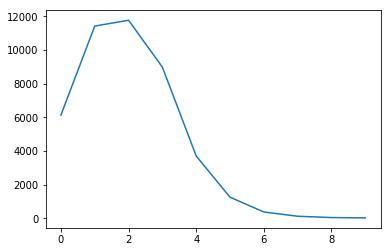

In [270]:
# 전체 kp 지수의 분포

plt.plot(total_concat.value.value_counts().sort_index())

In [239]:
np.unique(lr_l1_total.predict(test.iloc[:,:-1]), return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 47, 154, 138,  25,   1], dtype=int64))

In [343]:
np.unique(lr_l2_total.predict(test.iloc[:,:-1]), return_counts=True)

(array([1, 2, 3, 5], dtype=int64), array([200, 141,  23,   1], dtype=int64))

> 분포도는 problem 데이터에서도 동일한 양상을 보인다.

In [246]:
# problem 데이터 전처리작업

problem_pre = problem.copy()
problem_pre["year"] = 2019
problem_pre = pd.concat([ace_grouper(problem_pre, "mean"), 
                         ace_grouper(problem_pre, "min"), 
                         ace_grouper(problem_pre, "max")], axis=1)
problem_pre.drop(columns=["date", "kp_h"], inplace=True)

In [335]:
# l1의 분포도 확인
result = lr_l1_total.predict(problem_pre)
np.unique(result, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([  19, 1175, 1281,  418,   27], dtype=int64))

In [344]:
#l2의 분포도 확인

result = lr_l2_total.predict(problem_pre)
np.unique(result, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([1201, 1303,  407,    4,    5], dtype=int64))

> LogisticRegression에서는 l1이나 l2 모두 kp 지수 6이상을 예측한 경우는 없었다.

> 전체 kp 지수의 분포와 더 유사한 형태를 띠는 것은 l1이므로, l1을 최종 모델로 선택했다.

In [340]:
# csv화

result = result.reshape((-1, 8))
result = pd.DataFrame(result, columns=target.columns[1:-1], index=range(1, len(result)+1))
result.head()

,kp_0h,kp_3h,kp_6h,kp_9h,kp_12h,kp_15h,kp_18h,kp_21h
1,4,3,2,2,1,2,2,2
2,2,2,2,2,2,1,1,1
3,1,1,2,2,2,2,2,1
4,1,2,1,1,2,2,2,2
5,1,1,2,2,2,2,3,3


In [341]:
result.tail()

,kp_0h,kp_3h,kp_6h,kp_9h,kp_12h,kp_15h,kp_18h,kp_21h
361,3,3,2,2,3,2,2,3
362,2,2,2,2,2,2,2,2
363,2,2,2,2,2,1,1,1
364,1,1,1,1,1,1,1,1
365,1,1,1,1,1,1,1,1


In [342]:
result.to_csv("result.csv")

---

## knn

In [189]:
from sklearn.neighbors import KNeighborsClassifier

In [216]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn300 = KNeighborsClassifier(n_neighbors=300)

In [217]:
knn5.fit(train.iloc[:,:-1], train.value)
knn300.fit(train.iloc[:,:-1], train.value)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=300, p=2,
           weights='uniform')

In [218]:
weightedRMSE(knn5, test)

1.2513407443764413

In [219]:
weightedRMSE(knn300, test)

1.0024360572028963

---

> 그램에서 svm이 안돌아간다....

In [169]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()

In [ ]:
svc.fit(train.iloc[:,:-1], train.value)

In [ ]:
weightedRMSE(svc, test)